Перед вами таблица с результатами A/B-теста. В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.

Задача

Нужно понять, стали ли мы больше зарабатывать с пользователя или нет. Вы уже знаете о существовании t-теста, U-теста Mann-Whitney и бутстрапа. Открытый вопрос: какой инструмент использовать?

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import scipy.stats as ss
from scipy.stats import normaltest
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg
%matplotlib inline

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
sns.set(
    font_scale = 2, 
    style = "whitegrid", 
    rc = {'figure.figsize':(12,8)})

In [3]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-tulnikov-27/STATISTIKA/hw_bootstrap.csv', sep = ';', index_col= 0, decimal=',')
df.head()

,value,experimentVariant
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control


In [4]:
df.dtypes

value                float64
experimentVariant     object
dtype: object

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


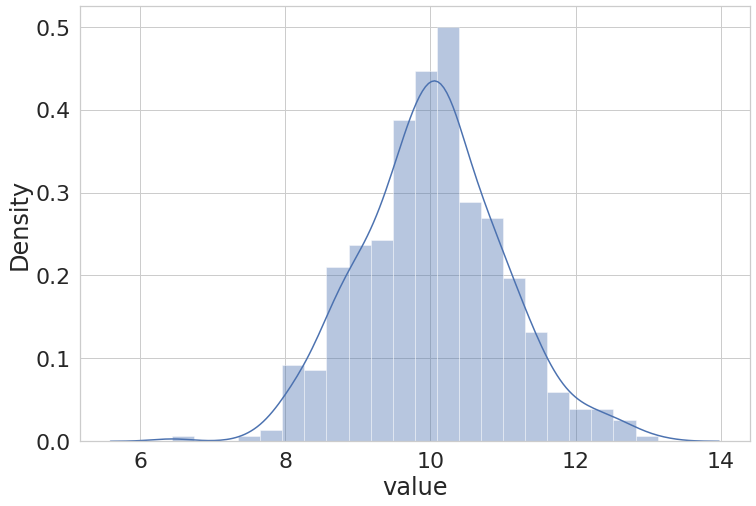

In [5]:
df_Control = df.query('experimentVariant == "Control"')
sns.distplot(df_Control.value)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


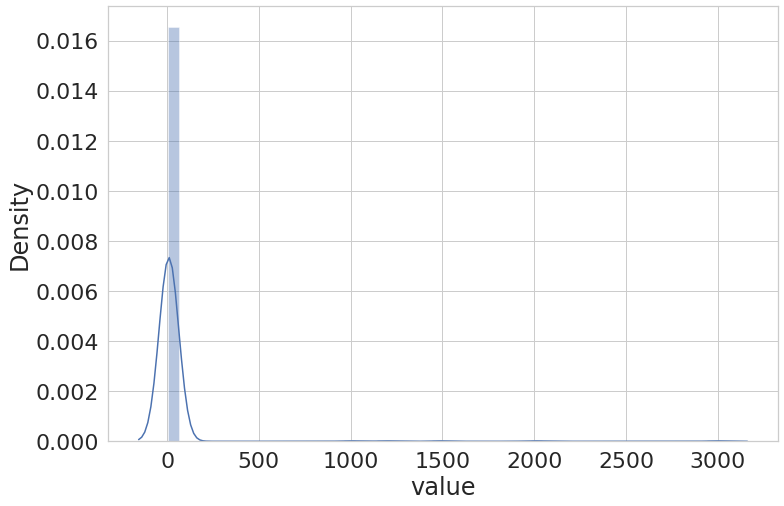

In [6]:
df_Test = df.query('experimentVariant == "Treatment"')
sns.distplot(df_Test.value)

В контрольной группе наблюдается нормлаьное распределение, что не скажешь о тестовой группе

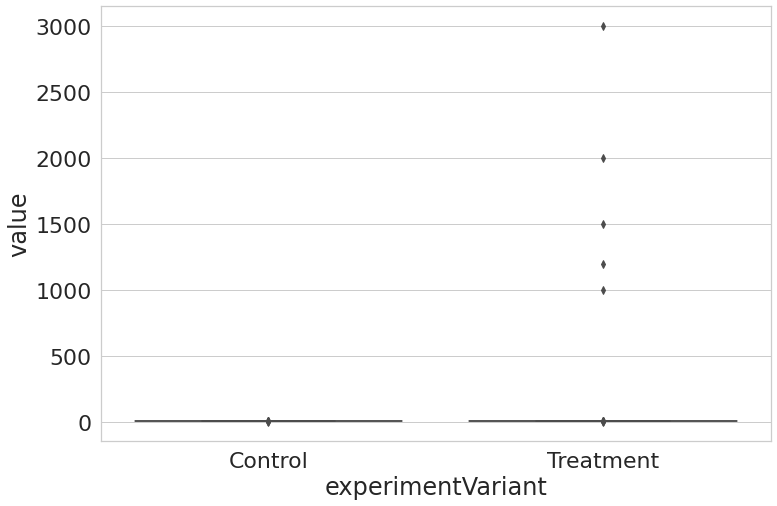

In [7]:
sns.boxplot(x="experimentVariant", y="value", data=df)

Судя по графику могу сделать вывод, что в тестовой группе наблюдается ненормальность распределения из-за довольно больших выбросов

Проведем T test

In [8]:
ttest_ind(df[df.experimentVariant == 'Treatment'].value,
          df[df.experimentVariant == 'Control'].value)

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.038437593613498765)

Применим непараметрический тест Манна-Уитни

In [10]:
mannwhitneyu(df_Test.value, df_Control.value) 

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

In [11]:
# mannwhitneyu(df[df.experimentVariant == 'Treatment'].value,
          # df[df.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

Теперь проверим последний статистический метод bootstrap и посчитаем его pvalue

In [40]:
def get_bootstrap(
    df_Test, # числовые значения первой выборки
    df_Control, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = df_Test.sample(
            len(df_Test), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = df_Control.sample(
            len(df_Control), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

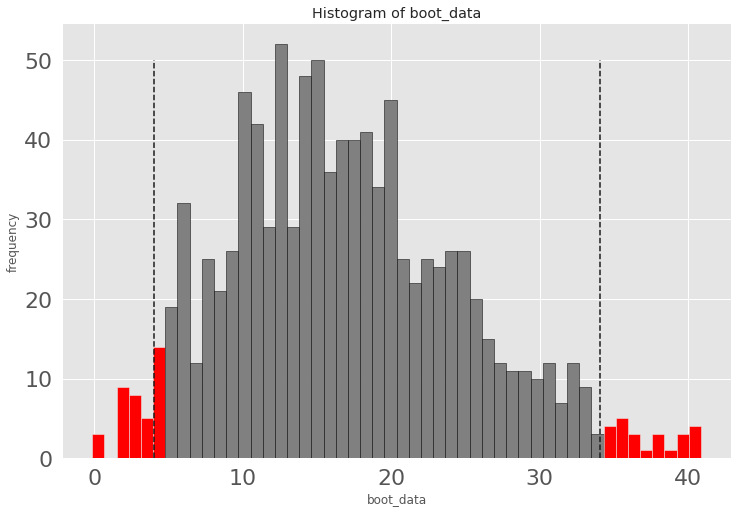

In [41]:
booted_data = get_bootstrap(df_Test.value, df_Control.value) # в результате хранится разница двух распределений, ДИ и pvalue

Результат расчета по среднему значению

In [42]:
booted_data["p_value"]

0.030906100670494364

In [43]:
booted_data["quants"]

,0
0.025,4.001084
0.975,34.071364


Так же можно посчиать по медиане 

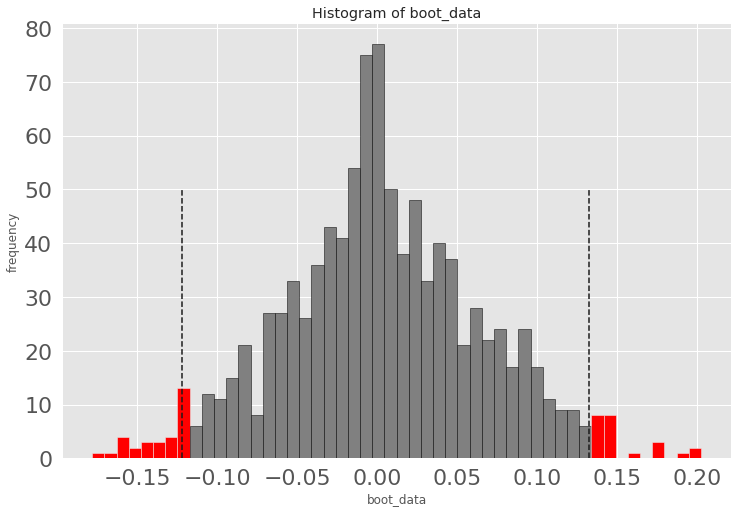

In [44]:
booted_data = get_bootstrap(df_Test.value, df_Control.value, statistic = np.median)

In [45]:
booted_data["p_value"]

0.9533010568482032

In [46]:
booted_data["quants"]

,0
0.025,-0.121790
0.975,0.132459


bootstrap by median = 0.95

т.к. pvalue больше 0,05, то изменений никаких между группами нет, смотря на график видим, что 0, попадает в доверительный интервал, что говорит нам о том, что нулевая гипотеза на заданном уровне значимости принимается.

В данной эксперименте лучше всего подойдет метод BOOTSTRAP с подсчетом медианы и U-теста Mann-Whitney который делает ранжирование данных, сортирует их по возрастанию, присваивает свои ранговые значения, а затем делает вычисления именно по рангу, а не по реальным значениям столбцов, а т-тест лучше применять на нормальном распределении ибо он сильно чувствителен к выбросам, которые мы можем наблюдать на графике.